In [2]:
from python_graphql_client import GraphqlClient
import json
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy

In [3]:
mapdata = dict()

with open('data/zonemap.json', 'r') as f:
    mapdata = json.load(f)

zones = mapdata['data']['zonesStats']
zones_map = {zone['zone']: zone['name'] for zone in zones}
channels = mapdata['data']['zonesGraphs']

In [ ]:
marketdata_raw = dict()
with open('data/marketcap.json', 'r') as f:
    marketdata_raw = json.load(f)

marketdata = dict()
for asset in marketdata_raw['data']['assets']:
    marketdata[asset['blockchain']['name']] = asset['marketCap']

In [5]:
G = nx.Graph()
for zone in zones:
    if zone['name'] in marketdata and marketdata[zone['name']] != None:
        market_cap = int(marketdata[zone['name']])
        G.add_node(zone['zone'], weight=market_cap)

for chan in channels:
    if chan["ibcVolume"] == 0:
        continue
    if chan["source"] not in G.nodes:
        continue
    if chan['target'] not in G.nodes:
        continue
    G.add_edge(chan["source"], chan["target"], weight=chan["ibcVolume"])

G

In [6]:
total_cap = 0

for node in G.nodes():
    total_cap += G.nodes[node]['weight']
print(total_cap)

9309518673


In [7]:
def aggregate_node_weights(G, path):
    """
    Calculate sum of the weights in a path.
    """
    return sum(G.nodes[node]['weight'] for node in path)

def find_heaviest_path(G, source, target):
    """
    Find the heaviest path between source and target nodes.
    """
    max_path = []
    max_weight = 0
    for path in nx.all_simple_paths(G, source, target):
        weight = aggregate_node_weights(G, path)
        if weight > max_weight:
            max_path = path
            max_weight = weight
    return max_path, max_weight

import itertools

def find_heaviest_path_all(G):
    max_path = []
    max_weight = 0
    nodes = list(G.nodes)
    combinations = list(itertools.combinations(nodes, 2))
    print(combinations)
    for combination in combinations:
        source = combination[0]
        target = combination[1]
        print(source, target, end=' ')
        max_path1, max_weight1 = find_heaviest_path(G, source, target)
        print(max_path1, max_weight1)
        if max_weight1 > max_weight:
            max_path = max_path1
            max_weight = max_weight1


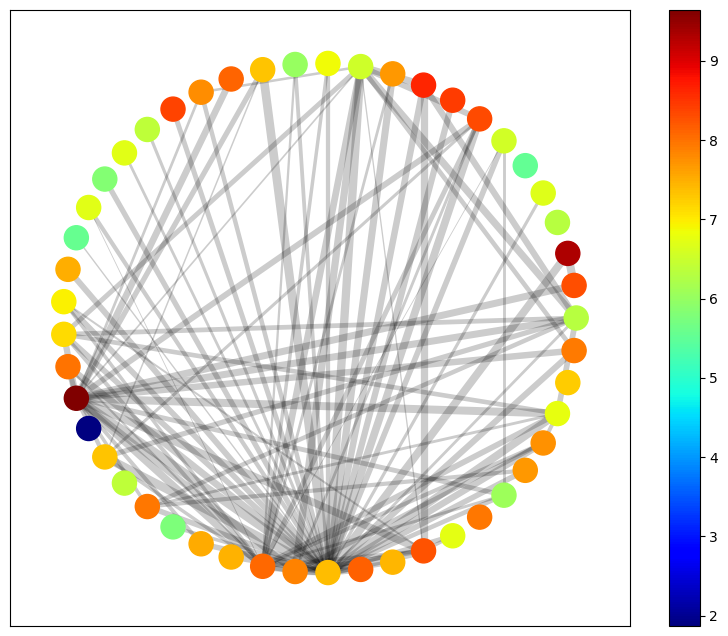

In [8]:
node_labels = {node: zones_map[node] for node in G.nodes}
node_weights = [math.log10(G.nodes[node]['weight']) for node in G.nodes]
edge_weights = [math.log10(edge[2]) for edge in G.edges(data='weight')]

fig = plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)
ec = nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, node_labels, node_color=node_weights, cmap=plt.cm.jet)
# labels = nx.draw_networkx_labels(G,pos,node_labels,font_size=16,font_color='r')

plt.colorbar(nc)
plt.show()